In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from pylanetary.planetnav import *
import astropy.units as u
from shift_stack_moons.shift_stack_moons import chisq_stack
from astropy.io import fits
from astropy import io
from datetime import datetime, timedelta
from astroquery.jplhorizons import Horizons
from image_registration.chi2_shifts import chi2_shift
from image_registration.fft_tools import shift2d
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
import paths

# Navigation on LBTI lucky fringing data

## Workflow

0. load and organize the data
1. align all the frames relative to one another - see chisq-align.ipynb
2. select the lucky ones - done by Al's ugrad student
3. navigate each lucky frame with planetnav model disk
    - times from text file Al sent me
    - PSF from observations of Emakong itself
4. determine location of Emakong in each lucky frame
5. spread in Emakong locations gives the astrometric uncertainty somehow

## 0. load and organize the data

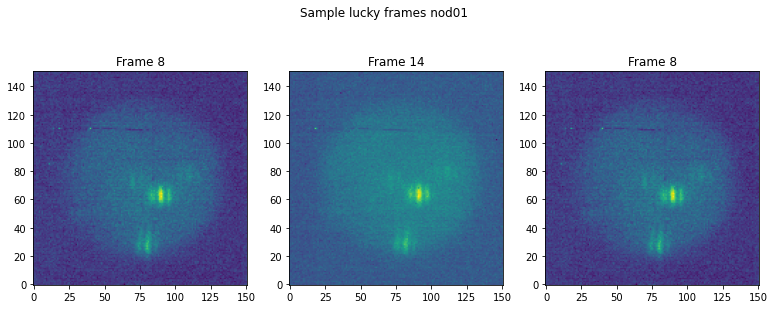

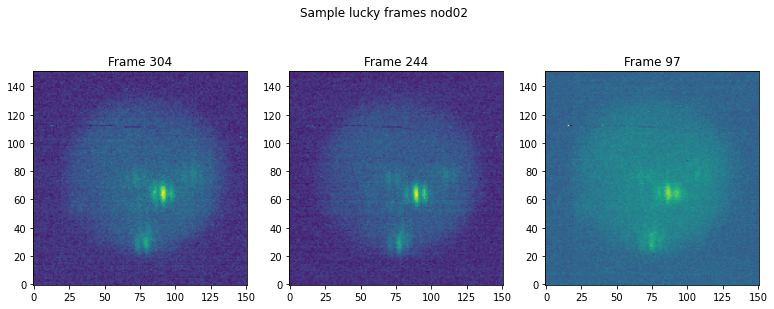

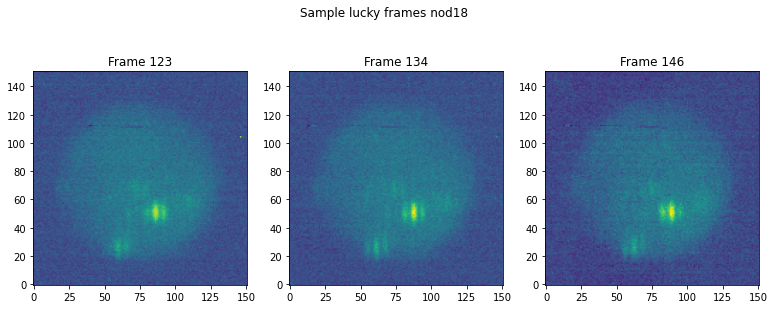

In [15]:
frameids = ['01', '02', '18']

frames = []
lucky_frames = []
lucky_times = []
lucky_angles = []
for fid in frameids:
    stem = f'nod{fid}'

    # fits file of data frames
    hdul = fits.open(paths.data / f'{stem}disk.fits')
    framesi = hdul[0].data
    hdr = hdul[0].header
    frames.append(framesi)

    # text file of lucky frames
    lucky_ids = np.loadtxt(paths.data / f'{stem}log.txt', delimiter = ',').T[0].astype(int) - 1
    l_frames = framesi[lucky_ids]
    lucky_frames.append(l_frames)

    # plot some sample lucky frames
    fig, axes = plt.subplots(1,3, figsize = (13, 5))
    for ax in axes:
        i = np.random.choice(lucky_ids.size)
        ax.imshow(l_frames[i], origin='lower')
        ax.set_title(f'Frame {lucky_ids[i]}')
    fig.suptitle(f'Sample lucky frames {stem}')
    plt.show()

    # text file of frame times
    frame_hours = []
    with open(paths.data / f'{stem}utc.txt', 'r') as f:
        for l in f:
            seconds_utc = float(l[45:53])*3600
            time_utc = timedelta(seconds = seconds_utc)
            frame_hours.append(time_utc)
    obsdate = datetime.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    frame_times = np.array([obsdate + delta for delta in frame_hours])
    lucky_times.append(frame_times[lucky_ids])

    # text file of parallactic angles
    parallaxes = []
    with open(paths.data / f'{stem}para.txt', 'r') as f:
        for l in f:
            parallaxes.append(float(l[45:53]))
    rotation_angles = np.array(parallaxes) #ccw
    lucky_angles.append(rotation_angles[lucky_ids])
    

frames = np.concatenate(frames)
lucky_frames = np.concatenate(lucky_frames)
lucky_times = np.concatenate(lucky_times)
lucky_angles = np.concatenate(lucky_angles)

### 0.1. Load and organize PSF frames - superseded by make-psf.ipynb

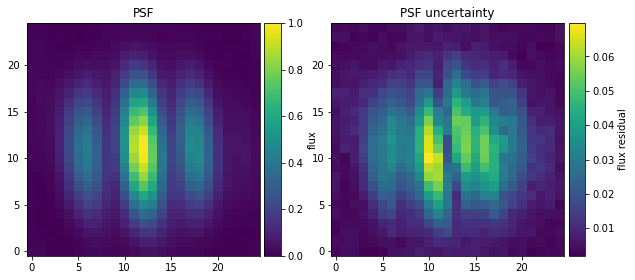

In [16]:

# fits file of PSF frame
hdul = fits.open(paths.data / f'slctdPsfCube.fits')
psf_frames = hdul[0].data

# normalize so maximum is unity, chisq align, then take the mean
psf_frames = np.array([fr/np.max(fr) for fr in psf_frames])
aligned_psf_frames = chisq_stack(psf_frames, showplot = True, edge_detect=False)
psf = np.mean(aligned_psf_frames, axis = 0)
psf /= np.max(psf)
psf_uncertainty = np.std(aligned_psf_frames, axis = 0)
psf_uncertainty /= np.max(psf)

# plot the PSF
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 6))
cim0 = ax0.imshow(psf, origin = 'lower')
ax0_divider = make_axes_locatable(ax0)
# Add an Axes to the right of the main Axes.
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(cim0, cax=cax0, label = 'flux')

cim1 = ax1.imshow(psf_uncertainty, origin = 'lower')
ax1_divider = make_axes_locatable(ax1)
# Add an Axes to the right of the main Axes.
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(cim1, cax=cax1, label = 'flux residual')

ax0.set_title('PSF')
ax1.set_title('PSF uncertainty')

plt.show()
plt.close()


(12.410730444939775, 12.451136488724014)


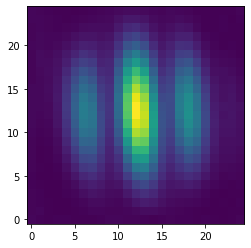

In [17]:

# center the PSF using center of mass
ctr = ndimage.center_of_mass(psf)
shp = psf.shape
dx = shp[0]/2. - ctr[0]
dy = shp[1]/2. - ctr[1]
psf = shift2d(psf,dy,dx)
print(ndimage.center_of_mass(psf)) #should equal 12.5, 12.5
plt.imshow(psf, origin='lower')
plt.show()


In [18]:
import pickle
with open(paths.data / 'psf_fittable_model.pkl', 'rb') as f:
    epsf = pickle.load(f)
print(epsf)

Model: EPSFModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    flux x_0 y_0
    ---- --- ---
     1.0 0.0 0.0


## 3. navigate lucky frames with planetnav

In [35]:
pixscale_arcsec = 0.01071 #arcsec, lbti
req = 1821 #km
rpol = req #circular
# limb-darkened disk model parameters
flux = 15 # surface brightness in whatever units are in the fits file
a = 0.0 # exponential limb-darkening law exponent
fwhm = 0.1 # approximate FWHM of the point-spread function in arcsec

data_out = np.empty(lucky_frames.shape)
lats_out = np.empty(lucky_frames.shape)
lons_out = np.empty(lucky_frames.shape)
mus_out = np.empty(lucky_frames.shape)

rmsvals = []
nav_errs_x = []
nav_errs_y = []
nav_x = []
nav_y = []
for i, obstime in enumerate(lucky_times):
    
    frame = lucky_frames[i]
    angle = lucky_angles[i]
    
    # call Horizons for the appropriate datetime
    end_time = obstime + timedelta(minutes=1)
    epochs = {'start':obstime.strftime('%Y-%m-%d %H:%M:%S'), 
              'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 
              'step':'1m'}
    # convert pixscale from arcsec to km
    obj = Horizons(id='501', location='G83', epochs=epochs) #Io, Mt Graham
    ephem = obj.ephemerides()
    d_AU = ephem['delta'][0]*u.au
    dist = d_AU.to(u.km).value
    pixscale_km = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))
    
    # adjust north pole angle according to parallactic angle
    npang = ephem[0]['NPole_ang']
    #ephem[0]['NPole_ang'] = (npang + angle)%360
    ephem[0]['NPole_ang'] = (npang - angle)%360
    
    # make a planetnav object
    nav = Nav(frame, ephem[0], req, rpol, pixscale_arcsec)
    
    # find per-frame rms noise
    n = 20
    err_region = np.concatenate([frame[:n, :n].flatten(),
                           frame[-n:, :n].flatten(),
                           frame[:n, -n:].flatten(),
                           frame[-n:, -n:].flatten(),])
    rms_noise = np.std(err_region)
    rmsvals.append(rms_noise)
    
    # try centering using convolution with disk
    #ldmodel = nav.ldmodel(flux, a, beam = fwhm, law='exp')
    #dx, dy, dxerr, dyerr = nav.colocate(mode='disk', 
    #                                    tb = flux, 
    #                                    a = a, 
    #                                    beam = fwhm, 
    #                                    err = rms_noise, 
    #                                    diagnostic_plot=False)
    
    ## data augmentation step:
    ## rotate the entire frame by several different angles, re-do colocate
    ## this decreases the uncertainty
    dx1s, dy1s = [], []
    dx2s, dy2s = [], []
    for angle in np.linspace(0,360,10):
        framer = ndimage.rotate(frame, angle, reshape=False)
        nav.data = framer
        dx1, dy1, dxerr1, dyerr1 = nav.colocate(mode='disk', 
                                        tb = flux, 
                                        a = a, 
                                        beam = epsf.data, 
                                        err = rms_noise, 
                                        diagnostic_plot=False)
        # de-rotate dx, dy back as though they were not at an angle
        # simple vector rotation formula
        # 𝑥2=cos𝛽 𝑥1 − sin𝛽 𝑦1
        # 𝑦2=sin𝛽 𝑥1 + cos𝛽 𝑦1
        dx2 = np.cos(np.deg2rad(angle))*dx1 - np.sin(np.deg2rad(angle))*dy1
        dy2 = np.sin(np.deg2rad(angle))*dx1 + np.cos(np.deg2rad(angle))*dy1
        dx2s.append(dx2)
        dy2s.append(dy2)
        dx1s.append(dx1)
        dy1s.append(dy1)
        
    ## this plot ensures that the computation of dx2, dy2 from dx1, dy1 is correct
    # plt.plot(dx2s, dy2s, label = 'post') 
    # plt.plot(dx1s, dy1s, label = 'pre')
    # plt.legend()
    # plt.show()
    dx, dy = np.mean(np.array(dx2s)), np.mean(np.array(dy2s))
    dxerr, dyerr = np.std(np.array(dx2s)), np.std(np.array(dy2s))
    
    nav.xy_shift_data(-dx, -dy)
    
    # re-project, ensuring same pixel scale / image size for all
    if i == 0:
        pixscale_to_use = nav.pixscale_arcsec
        projected, mu_projected = nav.reproject()
        proj_out = np.empty((lucky_times.size, projected.shape[0], projected.shape[1]))
        mu_proj_out = np.empty((lucky_times.size, projected.shape[0], projected.shape[1]))
        
    projected, mu_projected = nav.reproject(pixscale_arcsec = pixscale_to_use)
    #projected[np.isnan(projected)] = 0.0
    #print(f'brightest pixel (projected) = {np.unravel_index(np.argmax(projected), projected.shape)}')
    #plt.imshow(projected, origin = 'lower')
    #plt.show()
    
    data_out[i] = nav.data
    lats_out[i] = nav.lat_g
    lons_out[i] = nav.lon_w
    mus_out[i] = nav.mu
    proj_out[i] = projected
    mu_proj_out[i] = mu_projected
    nav_errs_x.append(dxerr)
    nav_errs_y.append(dyerr)
    nav_x.append(dx)
    nav_y.append(dy)
    
# save those as fits
data_hdu = fits.PrimaryHDU(data_out)
lats_hdu = fits.ImageHDU(lats_out)
lons_hdu = fits.ImageHDU(lons_out)
mus_hdu = fits.ImageHDU(mus_out)
proj_hdu = fits.ImageHDU(proj_out)
mu_proj_hdu = fits.ImageHDU(mu_proj_out)
hdul_out = fits.HDUList([data_hdu, lats_hdu, lons_hdu, mus_hdu, proj_hdu, mu_proj_hdu])
hdul_out[0].header = hdr
hdul_out[1].header = fits.Header({'DTYPE':'lat_g'})
hdul_out[2].header = fits.Header({'DTYPE':'lon_w'})
hdul_out[3].header = fits.Header({'DTYPE':'mu'})
hdul_out[4].header = fits.Header({'DTYPE':'proj'})
hdul_out[5].header = fits.Header({'DTYPE':'mu_proj'})

hdul_out.writeto(paths.data / 'lucky_nav.fits', overwrite=True, output_verify='fix+warn')

# save x, y location 
d_out = np.asarray([nav_x, nav_y])
np.save('diagnostic_data/xy_nav.npy', d_out)

New image will be 353 by 176 pixels
Pixel scale 32.659604 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659604 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659605 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659605 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659613 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659614 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659625 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659625 km = 0.973142 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659906 km = 0.973133 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659925 km = 0.973133 pixels per degree
New image will be 353 by 176 pixels
Pixel scale 32.659894 km = 0.973134 pixels per degree
New image 

 [astropy.io.fits.verify]


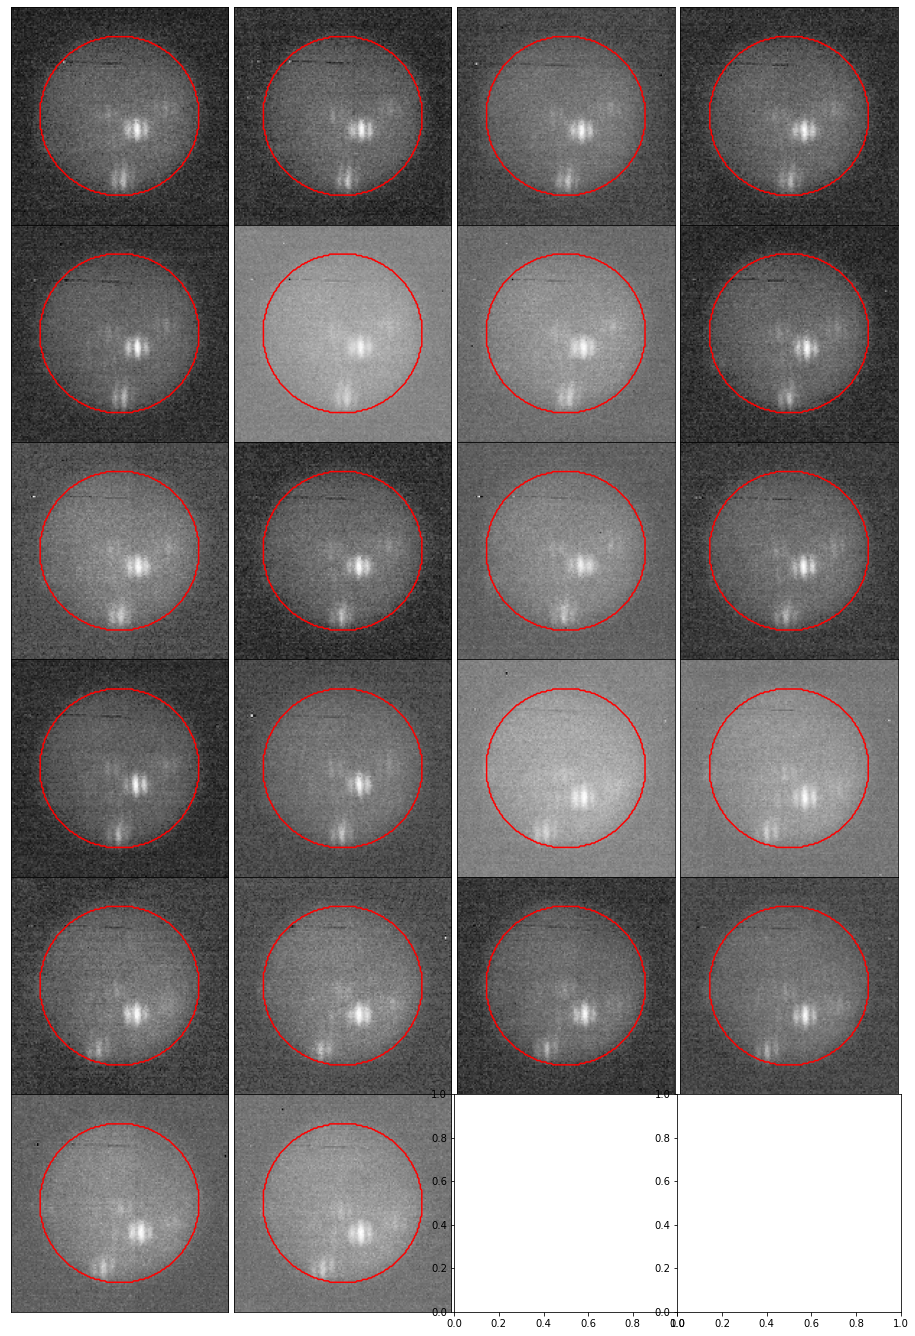

In [36]:
# make plots of all nav solutions for Imke
fig, axes = plt.subplots(6,4, figsize = (16, 24))

for i, frame in enumerate(data_out):
    
    lons = lons_out[i]
    circ = np.ones(lons.shape)
    circ[np.isnan(lons)] = -999
    
    ax = axes.flatten()[i]
    ax.imshow(data_out[i], origin='lower', cmap='Greys_r')
    ax.contour(circ, levels = [0], colors='red')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('diagnostic_plots/nav_solutions.png', dpi=300)
plt.show()

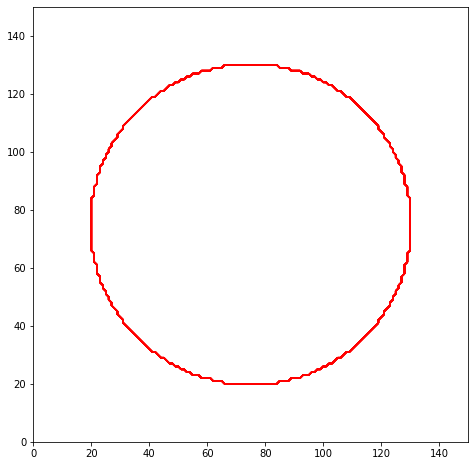

In [24]:
# stack all the solutions on each other to see how closely they match
fig, ax = plt.subplots(1,1, figsize = (8,8))

for i, frame in enumerate(data_out):
    
    lons = lons_out[i]
    circ = np.ones(lons.shape)
    circ[np.isnan(lons)] = -999
    
    ax.contour(circ, levels = [0], colors='red')
    ax.set_aspect('equal')

plt.show()

## 4. determine the location of Emakong via cross-correlation with a PSF

In [25]:
'''
# Make an average PSF from all the Emakong frames - replace this with real PSF determination
# align the PSFs to make an average PSF
aligned_psfs = chisq_stack(np.array(psfs[::-1]), showplot = True, edge_detect=False)
psf = np.mean(psfs, axis=0)
psf/=np.max(psf)
plt.imshow(psf, origin = 'lower')
plt.show()
'''

NameError: name 'psfs' is not defined

In [26]:
def latlon_interpf(lats):
    '''
    2-d cubic, curvature-minimizing interpolation for lat-lon grids
    see: scipy.interpolate.Regular2DInterpolator
    will only be valid when inputting x,y points with same shape as input lats (obviously)
    
    Parameters
    ----------
    lats: 2-D numpy array of latitudes or longitudes
    
    Returns
    -------
    interpf: interpolation function
    '''
    lats[np.isnan(lats)] = -999
    x = np.arange(lats.shape[0]) + 0.5 #add 1/2 so using center of each pixel
    y = np.arange(lats.shape[1]) + 0.5
    interp = RegularGridInterpolator((x, y), lats)
    return interp

# cross-correlate PSF with data to find Emakong location
emakong_lat = []
emakong_lon = []
emakong_x = []
emakong_y = []
emakong_err_x = []
emakong_err_y = []
for i in range(data_out.shape[0]):
    
    pad_width = int((data_out[i].shape[0] - 1)/2 - (psf.shape[0] - 1)/2)
    psf_pad = np.pad(psf, pad_width)
    frame = data_out[i] / np.max(data_out[i])
    rms = rmsvals[i]/np.max(data_out[i])
    [dx,dy,dxerr,dyerr] = chi2_shift(psf_pad, frame, err=rms)
    ctr = data_out[i].shape[0]/2
    loc = np.array([dy + ctr, dx + ctr])
    err_tot_x = np.hypot(dxerr, nav_errs_x[i])
    err_tot_y = np.hypot(dyerr, nav_errs_y[i])
    print(f'pixel location of Emakong: ({dx + ctr},{dy + ctr}) +/- ({err_tot_x},{err_tot_y})')
    
    # make an interpolation function out of lat/lon grid
    lat_interp = latlon_interpf(lats_out[i])
    lon_interp = latlon_interpf(lons_out[i])
    lat_f = lat_interp(loc)[0]
    lon_f = lon_interp(loc)[0]
    print(f'lat,lon at that location: {lat_f}, {lon_f}')
    # simple determination of brightest pixel for comparison
    # brightest_idx = np.unravel_index(np.argmax(data_out[i]), data_out[i].shape)
    # print(f'brightest pixel = {brightest_idx[::-1]}')
    # print(f'lat,lon of that pixel = {lats_out[i][brightest_idx]}, {lons_out[i][brightest_idx]}')
    
    emakong_x.append(loc[1])
    emakong_y.append(loc[0])
    emakong_lat.append(lat_f)
    emakong_lon.append(lon_f)
    emakong_err_x.append(err_tot_x)
    emakong_err_y.append(err_tot_y)

pixel location of Emakong: (87.525390625,66.384765625) +/- (0.3076182172893692,0.31496961353240577)
lat,lon at that location: -0.2833745199096491, 133.00304155339796
pixel location of Emakong: (88.572265625,66.150390625) +/- (0.3118800165644419,0.3209648831882919)
lat,lon at that location: -0.013190685926190951, 131.89648849045628
pixel location of Emakong: (86.623046875,65.513671875) +/- (0.30206373198847536,0.3095534375375496)
lat,lon at that location: -1.4987062928798351, 133.42603003482455
pixel location of Emakong: (86.431640625,65.572265625) +/- (0.30169545175175716,0.31151737696897197)
lat,lon at that location: -1.5115994796937056, 133.6622662382074
pixel location of Emakong: (87.818359375,65.689453125) +/- (0.3009011451886122,0.31285150469188455)
lat,lon at that location: -0.7554359363386087, 132.41709590137236
pixel location of Emakong: (87.955078125,65.919921875) +/- (0.30600886469630756,0.31638753450909396)
lat,lon at that location: -0.44830140819446795, 132.4412405526001
pi

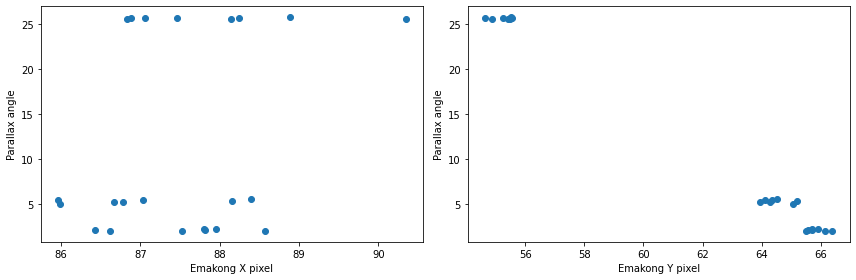

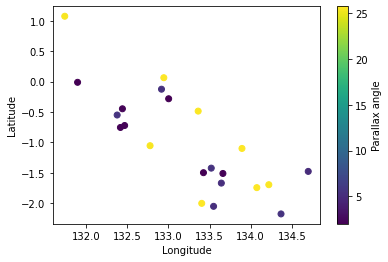

In [27]:
# check for systematics
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (12, 4))
ax0.scatter(emakong_x, lucky_angles)
ax0.set_xlabel('Emakong X pixel')
ax0.set_ylabel('Parallax angle')
ax1.scatter(emakong_y, lucky_angles)
ax1.set_xlabel('Emakong Y pixel')
ax1.set_ylabel('Parallax angle')
plt.tight_layout()
plt.show()

plt.scatter(emakong_lon, emakong_lat, c=lucky_angles)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Parallax angle')
plt.show()

group 0
x, y variance in disk location 1.1985759321213474 0.5454116283239449
x, y variance in difference 1.7110986937893429 0.8238342761568762
group 1
x, y variance in disk location 1.2410778728025882 0.3549373740299233
x, y variance in difference 1.5271399053784642 0.7511488012812619
group 2
x, y variance in disk location 1.4500064858758377 0.47046790688081336
x, y variance in difference 2.2470106634911318 0.7510056838949309


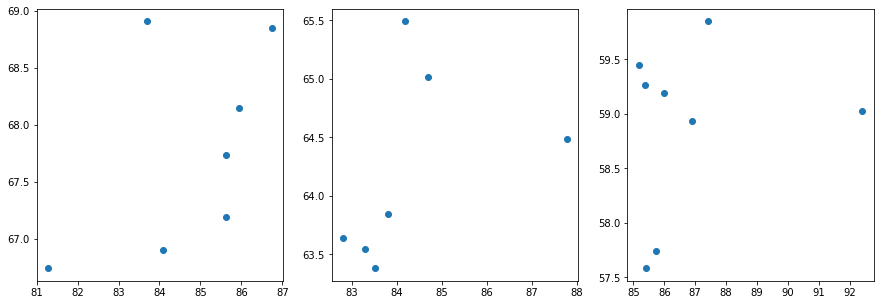

In [42]:
## check spread in x, y position of Emakong minus disk
emakong_x = np.array(emakong_x)
emakong_y = np.array(emakong_y)
nav_x = np.array(nav_x)
nav_y = np.array(nav_y)

diff_x = emakong_x - nav_x
diff_y = emakong_y - nav_y

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

ax0.scatter(diff_x[:7], diff_y[:7])
print("group 0")
print('x, y variance in disk location', np.std(nav_x[:7]), np.std(nav_y[:7]))
print('x, y variance in difference', np.std(diff_x[:7]), np.std(diff_y[:7]))

ax1.scatter(diff_x[7:14], diff_y[7:14])
print("group 1")
print('x, y variance in disk location', np.std(nav_x[7:14]), np.std(nav_y[7:14]))
print('x, y variance in difference', np.std(diff_x[7:14]), np.std(diff_y[7:14]))

ax2.scatter(diff_x[14:], diff_y[14:])
print("group 2")
print('x, y variance in disk location', np.std(nav_x[14:]), np.std(nav_y[14:]))
print('x, y variance in difference', np.std(diff_x[14:]), np.std(diff_y[14:]))

plt.show()

## 5. compile results into astrometry final answer with uncertainty

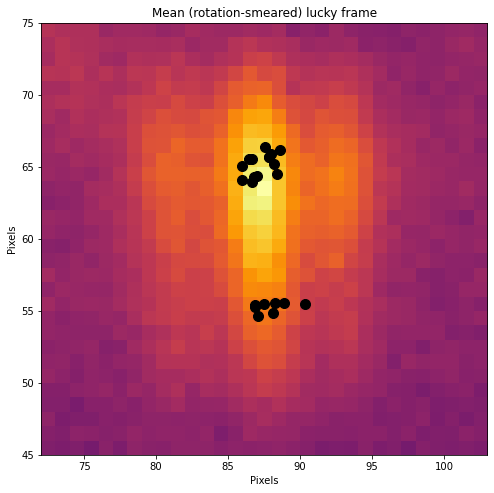

Final result is (87.52485795454545, 61.57333096590909) +/- (1.0172130936714034, 4.797069207053893) pixels
This does not account for planet rotation in any way


In [28]:
shp = np.mean(data_out, axis=0).shape
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(np.mean(data_out, axis=0), origin = 'lower', cmap = 'inferno', 
          extent = [0, shp[0], 0, shp[1]]) #note extent is necessary or else will plot from -0.5 to 150.5
ax.errorbar(np.array(emakong_x), np.array(emakong_y), xerr = emakong_err_x, yerr = emakong_err_y, 
            color = 'k', marker = 'o', linestyle = '', markersize = 10)
ax.set_xlim([72, 103])
#ax.set_ylim([55, 75])
ax.set_ylim([45, 75])
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Mean (rotation-smeared) lucky frame')
fig.savefig(f'diagnostic_plots/emakong_loc_pixel.png', dpi=300)
plt.show()

x = np.mean(emakong_x)
y = np.mean(emakong_y)
std_x = np.std(emakong_x)
std_y = np.std(emakong_y)
print(f'Final result is {x,y} +/- {std_x, std_y} pixels')
print('This does not account for planet rotation in any way')
# TO DO: check for off-by-one errors!

Emakong location is -0.9845975698002907 N, 133.21843792346127 W +/- (0.8116690929562836, 0.7757487387977953)
This accounts for rotation of both Earth and Io


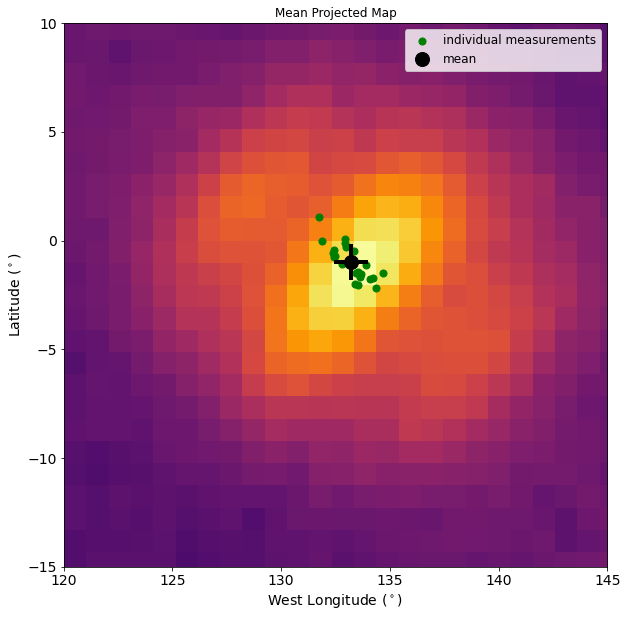

In [44]:
# do a projection
proj = np.mean(proj_out, axis=0)

# overplot the projection and the mean lat/lon
mean_lat = np.mean(emakong_lat)
lat_err = np.std(emakong_lat)
mean_lon = np.mean(emakong_lon)
lon_err = np.std(emakong_lon)
print(f'Emakong location is {mean_lat} N, {mean_lon} W +/- {lat_err, lon_err}')
print('This accounts for rotation of both Earth and Io')

# save the data for comparison with navigate-frames.ipynb
d_out = np.asarray([emakong_lon, emakong_lat])
np.save('diagnostic_data/latlon_nav.npy', d_out)

fs = 14
fig, ax = plt.subplots(1,1, figsize = (10,10))

ax.imshow(proj, origin = 'lower', extent = [0, 360, -90, 90], cmap='inferno')
ax.scatter(emakong_lon, emakong_lat, label = 'individual measurements', s=50, color = 'green')
ax.errorbar(mean_lon, mean_lat, yerr=lat_err, xerr=lon_err, 
             color = 'k', marker = 'o', linestyle = '', markersize=14, label = 'mean', elinewidth=4)
ax.set_ylabel(r'Latitude ($^\circ$)', fontsize = fs)
ax.set_xlabel(r'West Longitude ($^\circ$)', fontsize = fs)
ax.set_xlim([120, 145])
ax.set_ylim([-15, 10])
ax.tick_params(which='both', labelsize = fs)
ax.legend(fontsize = fs-2)
ax.set_title('Mean Projected Map', )
fig.savefig(paths.figures / 'emakong_loc_latlon.png', dpi=300)
plt.show()

## To-do list
- Explanation of the steps for Al
- Check if the rotation of Io is correctly applied or not
- Better workflow for doing all 18 nods without having to send emails back and forth
- Is 0.0109 arcsec the correct pixel scale? is 1821 km the correct radius?
- Propagate cross-correlation errors from pixel space to lat-lon space
- Why does the error space seem to be extended in the "wrong" direction?